In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import interact widget from ipywidgets
from ipywidgets import interact
np.random.seed(0)

## Building the network

In [2]:
# defining the derivative of the membrane potential
def dhdt(h, I, tau, R):
    return (R * I - h) / tau
# defining the transfer function
def transfer(h, alpha, beta):
    return (1/(1 + np.exp(-2 * alpha * (h - beta))))
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [3]:
def interactive_activation(alpha=.2, beta=.5):
    h_list = np.linspace(-10, 10, 1000)
    activation_list = transfer(h_list, alpha=alpha, beta=beta)

    plt.plot(h_list, activation_list, label='transfer function')
    plt.xlabel('h')
    plt.ylabel('transfer function')
    plt.legend()
    plt.show()

_ = interact(interactive_activation, alpha=(0.1, 2, 0.1), beta=(0.1, 2, 0.1))

interactive(children=(FloatSlider(value=0.2, description='alpha', max=2.0, min=0.1), FloatSlider(value=0.5, de…

## 0.1. Plot the transfer function g as a function of the potential h. How do α and β affect the shape?
- $\alpha$ is changing the slope of the transfer function, the higher the value the steeper the slope.
- $\beta$ is shifting the transfer function. The higher the value the more shifted to the right.



In [13]:
T = 1000 # ms
dt = .1 # ms
tau = 10 # ms
R = 1 # Ohm # needs to be asked on the units
r0 = 1 # mHz
alpha = 2 # mV^-1
beta = .5 # mV

N = 10 # number of neurons
h = np.zeros((N, int(T/dt)))
t = np.linspace(0, T, int(T/dt))
I0 = 2 # 1e-6 # nA
omega = 2e-2 # Hz
# I = np.zeros((N, int(T/dt))) # input current
# I_noisy = np.random.normal(0, 1, (N, int(T/dt)))
I = I0 * np.sin(omega * np.linspace(0, T, int(T/dt)))
# repeating the input current for all neurons
I = np.tile(I, (N, 1))
# I[:,:] = I0 * np.sin(omega * t)
rate = np.zeros((N, int(T/dt)))
spikes = np.zeros((N, int(T/dt)))

Text(0, 0.5, 'Current (A)')

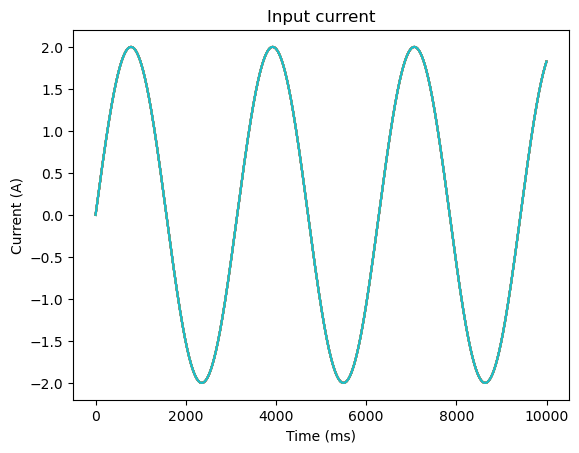

In [14]:
plt.plot(I.T)# + np.random.normal(0, .1, I.shape).T);
plt.title('Input current')
plt.xlabel('Time (ms)')
plt.ylabel('Current (A)')

In [15]:
for t in range(1, int(T/dt)):
    h[:, t] = h[:, t-1] + dt * dhdt(h[:, t-1], I[:, t-1], tau, R)
    rate[:, t] = r0 * transfer(h[:, t], alpha, beta)
    # spikes[:, t] = np.random.poisson(rate[:, t] * dt) > 0
    # if np.random.rand() > (rate[:, t] * dt).any():
        # spikes[:, t] = 1
    spikes[:, t] = np.random.binomial(1, rate[:, t] * dt)
    # if .any() > 0:
        # spikes[:, t] = 1
    

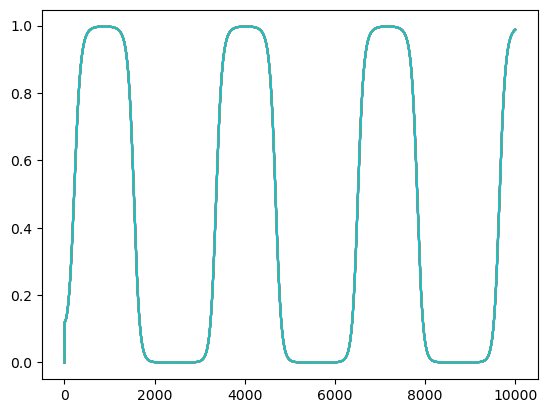

In [16]:
# plotting the rate of the neurons
for n in range(N):
    plt.plot(rate[n, :])# + np.random.normal(0, .01, rate.shape[1]), label=f'neuron {n}')

Text(0.5, 1.0, 'Spike raster')

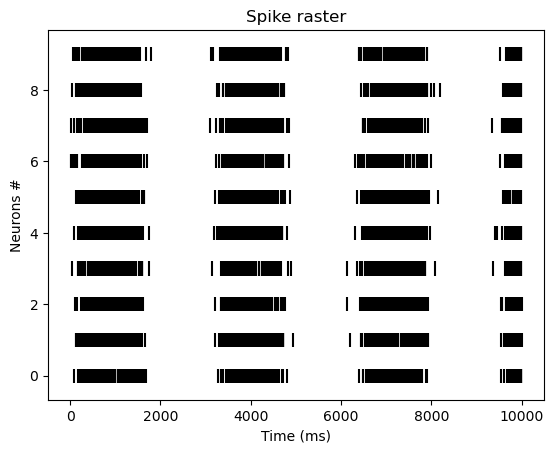

In [17]:
# plotting the spike raster
for n in range(N):
    spikes_n = np.where(spikes[n, :])[0]
    plt.vlines(spikes_n, n-.2, n+.2, color='black')
plt.xlabel('Time (ms)')
plt.ylabel('Neurons #')
plt.title('Spike raster')

In [18]:
def calculate_mean_rate(N, T, dt, spikes):
    # calculating the mean rate of the neurons
    mean_rate = np.zeros((N, T))
    bin_size = 10
    for t in np.arange(0, int(T/dt), bin_size):
        mean_rate[:, int(t*dt)] = np.mean(spikes[:, t:t+bin_size], axis=1)
    return mean_rate

Text(0.5, 0, 'Time (ms)')

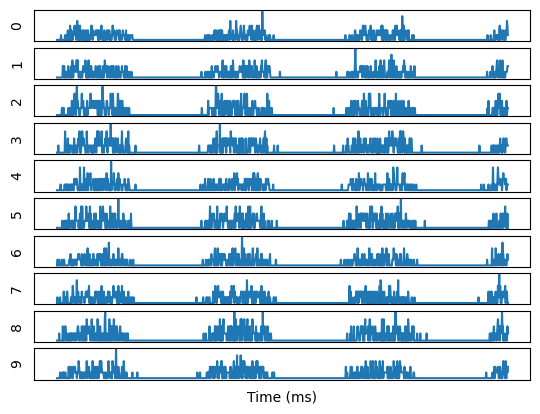

In [19]:
# calculating the mean rate of the neurons
# mean_rate = np.zeros((N, T))
# for t in np.arange(0, int(T/dt), 10):
#     mean_rate[:, int(t*dt)] = np.mean(spikes[:, t:t+10], axis=1)
mean_rate = calculate_mean_rate(N, T, dt, spikes)
# plotting the mean rate of the neurons 1 -10
plt.title('Mean rate of the neurons 1-10')
for n in range(10):
    plt.subplot(10, 1, n+1)
    plt.plot(mean_rate[n, :])
    plt.ylabel(f'{n}')
    plt.xticks([]); plt.yticks([])
plt.xlabel('Time (ms)')


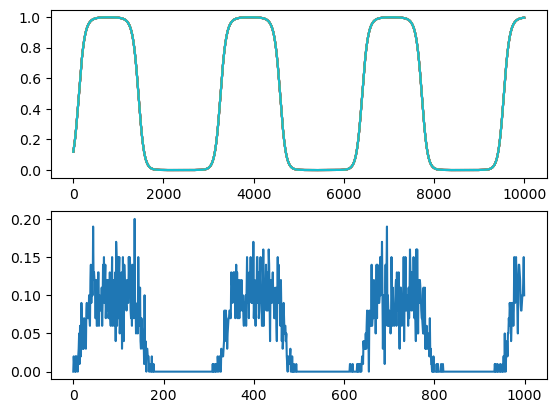

In [20]:
# comparing the theoretical rate with the mean rate of spiking neurons
theoretical_rate = r0 * transfer(R*I, alpha, beta)
plt.subplot(211)
plt.plot(theoretical_rate.T);
plt.subplot(212)
plt.plot(np.mean(mean_rate, axis=0))
# plt.plot(mean_rate[0, :])

## 0.2
- Since the spike generation is stochastic, the rate doesn't go as high as 1 (which is the maximum theoretical rate)
But it can go as high as .5 at some times.
- As long as there's no interactions between the neurons, the size of the network doesn't affect the simulation results.
- The numerical mean rate over the population tends to be smaller than the theoretical rate by a factor of 10 but it correctly follows the temporal aspects of the theoretical firing rate!

In [21]:
T = 1000 # ms
dt = .1 # ms
J = 5 # pC
N = 100
X = np.linspace(0, 2 * np.pi, N)
I = np.zeros((N, int(T/dt)))
h = np.random.uniform(0, 1, (N, int(T/dt)))
# h = np.zeros((N, int(T/dt)))
spikes = np.zeros((N, int(T/dt)))
rate = np.zeros((N, int(T/dt)))
tau = 10 # ms
R = 1 # Ohm # needs to be asked on the units
r0 = 1 # mHz
alpha = 2 # mV^-1
beta = .5 # mV

# for t in range(1, int(T/dt)):
for t in range(1, 2):
    m_cos = np.mean(np.cos(X) * spikes[:, t])
    m_sin = np.mean(np.sin(X) * spikes[:, t])
    # print(m_cos)
    I[:, t] = J/dt * (np.cos(X) * m_cos + np.sin(X) * m_sin)
    # print(I.shape)
    h[:, t] = h[:, t-1] + dt * dhdt(h[:, t-1], I[:, t-1], tau, R)
    rate[:, t] = r0 * transfer(h[:, t], alpha, beta)
    spikes[:, t] = np.random.binomial(1, rate[:, t] * dt)
    

In [22]:
def interactive_activation(J = 5):
    T = 100 # ms
    dt = .1 # ms
    N = 100
    X = np.linspace(0, 2 * np.pi, N)
    I = np.zeros((N, int(T/dt)))
    h = np.random.uniform(0, 1, (N, int(T/dt)))
    tau = 10 # ms
    R = 1 # Ohm # needs to be asked on the units
    r0 = 10 # mHz
    alpha = 2 # mV^-1
    beta = .5 # mV
    # h = np.zeros((N, int(T/dt)))
    spikes = np.zeros((N, int(T/dt)))
    rate = np.zeros((N, int(T/dt)))
    m_cos = 0
    m_sin = 0

    # spikes = np.random.binomial(1, np.ones(N) * dt, (N, int(T/dt)))
    # h = np.random.normal(0, 1, (N, int(T/dt)))
    for t in range(1, int(T/dt)):
        I[:, t] = J * (np.cos(X) * m_cos + np.sin(X) * m_sin)
        h[:, t] = h[:, t-1] + dt * dhdt(h[:, t-1], I[:, t-1], tau, R)
        rate[:, t] = r0 * transfer(h[:, t], alpha, beta)
        spikes[:, t] = np.random.binomial(1, rate[:, t] * dt)
        m_cos = np.mean(np.cos(X) * spikes[:, t])
        m_sin = np.mean(np.sin(X) * spikes[:, t])
    
    # figure = plt.figure(figsize=(10, 5))
    plt.subplot(311)
    plt.plot(I.T, color = 'black', alpha = .1)
    plt.ylabel('Input current')
    plt.subplot(312)
    plt.plot(rate.T, color = 'red', alpha = .1)
    plt.ylabel('Rate')
    plt.subplot(313)
    # plotting the spike raster
    for n in range(N):
        spikes_n = np.where(spikes[n, :])[0]
        plt.vlines(spikes_n, n-.5e1, n+.5e1, color='black')
    plt.xlabel('Time (ms)')
    plt.ylabel('Neurons #')
    plt.title('Spike raster')

_ = interact(interactive_activation, J=(0, 20, .1))

interactive(children=(FloatSlider(value=5.0, description='J', max=20.0), Output()), _dom_classes=('widget-inte…

## 1.1
The value $j=5 pC$ consistantly produce a bump attractor, although there are itterations for which $j=4 pC$ also shows the bump dynamics.

Text(0, 0.5, 'Rate')

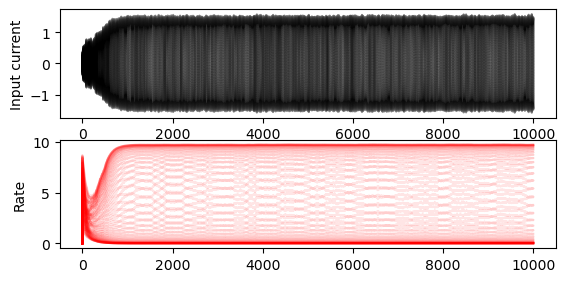

In [23]:
T = 1000 # ms
dt = .1 # ms
N = 100
X = np.linspace(0, 2 * np.pi, N)
I = np.zeros((N, int(T/dt)))
h = np.random.uniform(0, 1, (N, int(T/dt)))
tau = 10 # ms
R = 1 # Ohm # needs to be asked on the units
r0 = 10 # mHz
alpha = 2 # mV^-1
beta = .5 # mV
# h = np.zeros((N, int(T/dt)))
spikes = np.zeros((N, int(T/dt)))
rate = np.zeros((N, int(T/dt)))
m_cos = 0
m_sin = 0

# spikes = np.random.binomial(1, np.ones(N) * dt, (N, int(T/dt)))
# h = np.random.normal(0, 1, (N, int(T/dt)))
for t in range(1, int(T/dt)):
    I[:, t] = J * (np.cos(X) * m_cos + np.sin(X) * m_sin)
    h[:, t] = h[:, t-1] + dt * dhdt(h[:, t-1], I[:, t-1], tau, R)
    rate[:, t] = r0 * transfer(h[:, t], alpha, beta)
    spikes[:, t] = np.random.binomial(1, rate[:, t] * dt)
    m_cos = np.mean(np.cos(X) * spikes[:, t])
    m_sin = np.mean(np.sin(X) * spikes[:, t])

# figure = plt.figure(figsize=(10, 5))
plt.subplot(311)
plt.plot(I.T, color = 'black', alpha = .1)
plt.ylabel('Input current')
plt.subplot(312)
plt.plot(rate.T, color = 'red', alpha = .1)
plt.ylabel('Rate')
# plt.subplot(313)
# # plotting the spike raster
# for n in range(N):
#     spikes_n = np.where(spikes[n, :])[0]
#     plt.vlines(spikes_n, n-.5e1, n+.5e1, color='black')
# plt.xlabel('Time (ms)')
# plt.ylabel('Neurons #')
# plt.title('Spike raster')

# 1.2

356.3636363636364


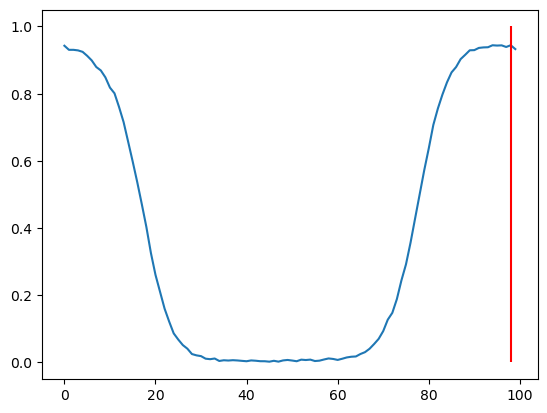

In [24]:
mean_rate = calculate_mean_rate(N, T, dt, spikes)
mean_over_time = np.mean(mean_rate, axis=1)
bump_angle = X[np.argmax(mean_over_time)]
print(bump_angle * 180 / np.pi)
plt.plot(mean_over_time)
plt.vlines(np.argmax(mean_over_time), 0, 1, color='red')
# plt.xlim([X[0], X[-1]])

In [25]:
circular_angle = np.zeros((N, T))
bump_angle = np.zeros(T)
for t in range(T):
    circular_angle[:, t] = mean_rate[:,t] * np.exp(1j * X).T
    x = mean_rate[:,t] * np.exp(1j * X).T
    bump_angle[t] = np.angle(np.sum(x))
    

/var/folders/m8/zm1w89m57wq8zmk8vcljy8ym0000gp/T/ipykernel_7617/1172408808.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  circular_angle[:, t] = mean_rate[:,t] * np.exp(1j * X).T


Text(0, 0.5, 'Neurons #')

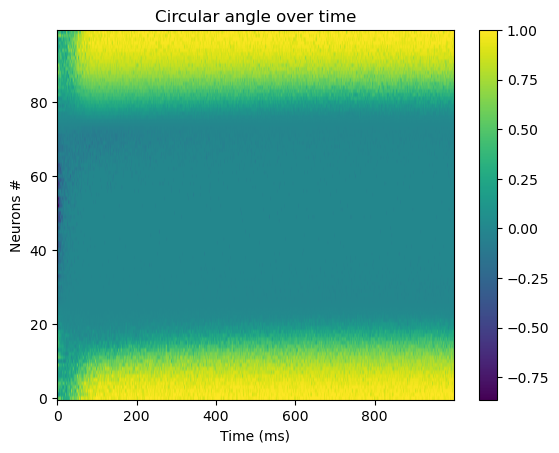

In [26]:
plt.imshow(circular_angle, origin='lower', aspect='auto')
plt.colorbar()
plt.title('Circular angle over time')
plt.xlabel('Time (ms)')
plt.ylabel('Neurons #')

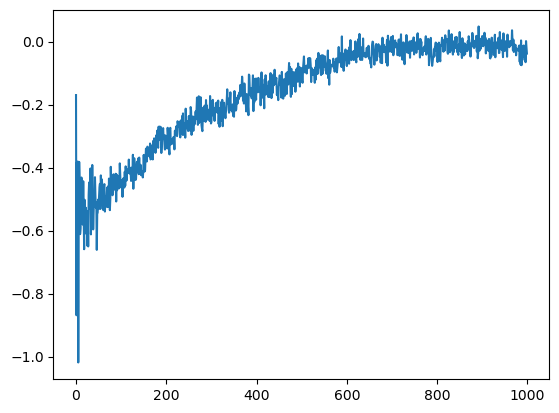

In [27]:
# bump_angle = np.mean(circular_angle, axis=0)
# bump_angle = []
plt.plot(bump_angle)

(100, 1000)